#### Training LDA modeles with a small training set 

##### First we import all the required packages

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim import models
from gensim.models import LdaModel, CoherenceModel
from gensim.models.wrappers import LdaMallet

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

D:\programs\anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['movie', 'film', 'review'])

In [3]:
# Import Dataset
file = 'samplereviews.xlsx'

xl = pd.ExcelFile(file)

df = xl.parse('Sheet1') 

df.head()

,movieName,MetacriticUserScore,Column3,Column4,reviewDate,Review,Column7,Column8,Column9,Column10,Innovativeness,Sentpos,Sentneg,Senttot,Genre,DomesticTotalGross,ProductionBudget,Runtime,Distributor,ReleaseDate
0,beachrats,6,whostosay,/user/whostosay,"Sep 11, 2017","[ ""A well crafted movie that exploits the inhe...",0,0,0,0,1,2,-4,-2,Drama,473771,0,98,Neon,2017-08-25
1,leap,7,LeZee,/user/LeZee,"Sep 3, 2017","[ ""Dreaming's easy, but chasing it needs all t...",0,0,0,0,3,3,-3,0,Animation,21858070,0,89,Weinstein Company,2017-08-25
2,leap,8,garwynn,/user/garwynn,"Sep 4, 2017","[ ""To start off, both the name of this movie a...",0,0,0,0,5,4,-2,2,Animation,21858070,0,89,Weinstein Company,2017-08-25
3,thehitmansbodyguard,0,imthenoob,/user/imthenoob,"Sep 6, 2017","[ ""There's no denying the obvious chemistry th...",1,2,1,1,1,3,-4,-1,Action Comedy,75468583,30000000,118,Lionsgate/Summit,2017-08-18
4,thehitmansbodyguard,6,marcmyworks,/user/marcmyworks,"Sep 2, 2017","[ ""As good as Ryan Reynolds is at playing Ryan...",0,1,0,1,1,3,-3,0,Action Comedy,75468583,30000000,118,Lionsgate/Summit,2017-08-18


In [4]:
# Convert to list
data = df.Review.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single and double quotes
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub('\", "', '', sent) for sent in data]
data = [re.sub('\\"', '', sent) for sent in data]
data = [re.sub('\"', '', sent) for sent in data]
data = [re.sub('[\\:"]', '', sent) for sent in data]

# Remove web links
data = [re.sub(r'^https?:\/\/.*[\r\n]*', '', sent) for sent in data]

pprint(data[:3])

['[ A well crafted movie that exploits the inherent drama of \\coming out\\ in '
 'an unwelcoming environment. Add drugs, booze and an unsympathetic group of '
 'friends to the mix and you have a complex, painful brew of frustrated, '
 'destructive yearning and self reflection - all exquisitely shown with '
 'masterful movie making. However, the movie lacks a third act and theres no '
 'resolution of the main troubled character. ]',
 '[ Dreamings easy, but chasing it needs all the effort.Well, I praise a lot, '
 'particularly the European animations for preserving the 2D animation. That '
 'does not mean they lack behind in 3D format. The recent film The Little '
 'Prince was the perfect example of a quality 3D animation outside Hollywood. '
 'Pars with Disney, Pixar standards. Technically, as well as the story '
 'contents. But the quantities are very less and also making it a bit '
 'expensive. So they usually prefer producing it in the English language for '
 'the wider/internationa

In [5]:
# Tokenize words and text clean up
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:3])

[['well', 'crafted', 'movie', 'that', 'exploits', 'the', 'inherent', 'drama', 'of', 'coming', 'out', 'in', 'an', 'unwelcoming', 'environment', 'add', 'drugs', 'booze', 'and', 'an', 'unsympathetic', 'group', 'of', 'friends', 'to', 'the', 'mix', 'and', 'you', 'have', 'complex', 'painful', 'brew', 'of', 'frustrated', 'destructive', 'yearning', 'and', 'self', 'reflection', 'all', 'exquisitely', 'shown', 'with', 'masterful', 'movie', 'making', 'however', 'the', 'movie', 'lacks', 'third', 'act', 'and', 'theres', 'no', 'resolution', 'of', 'the', 'main', 'troubled', 'character'], ['dreamings', 'easy', 'but', 'chasing', 'it', 'needs', 'all', 'the', 'effort', 'well', 'praise', 'lot', 'particularly', 'the', 'european', 'animations', 'for', 'preserving', 'the', 'animation', 'that', 'does', 'not', 'mean', 'they', 'lack', 'behind', 'in', 'format', 'the', 'recent', 'film', 'the', 'little', 'prince', 'was', 'the', 'perfect', 'example', 'of', 'quality', 'animation', 'outside', 'hollywood', 'pars', 'wit

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=75) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=75)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[3]]])

D:\programs\anaconda\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['theres', 'no', 'denying', 'the', 'obvious', 'chemistry', 'that', 'jackson', 'and', 'reynolds', 'have', 'on', 'screen', 'and', 'would', 'to', 'see', 'them', 'together', 'in', 'any', 'other', 'movie', 'but', 'this', 'this', 'movie', 'sucked', 'so', 'much', 'that', 'it', 'became', 'the', 'first', 'film', 'have', 'ever', 'walked', 'out', 'early', 'on', 'the', 'plot', 'is', 'terribly', 'generic', 'and', 'could', 'be', 'called', 'within', 'the', 'first', 'minutes', 'terrible', 'use', 'of', 'the', 'fantastic', 'gary_oldman', 'idk', 'why', 'he', 'would', 'ever', 'take', 'role', 'like', 'this', 'to', 'begin', 'with', 'the', 'movie', 'is', 'just', 'garbage', 'dont', 'even', 'bother']


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

[['well', 'craft', 'exploit', 'inherent', 'drama', 'come', 'unwelcom', 'environment', 'add', 'drug', 'booze', 'unsympathetic', 'group', 'friend', 'mix', 'complex', 'painful', 'brew', 'frustrate', 'destructive', 'yearning', 'self', 'reflection', 'exquisitely', 'show', 'masterful', 'making', 'however', 'lack', 'third_act', 'there', 's', 'resolution', 'main', 'troubled', 'character'], ['dreaming', 'easy', 'chasing', 'need', 'effort', 'well', 'praise', 'lot', 'particularly', 'european', 'animation', 'preserve', 'animation', 'mean', 'lack', 'format', 'recent', 'little', 'prince', 'perfect', 'example', 'quality', 'animation', 'hollywood', 'par', 'disney', 'pixar', 'standard', 'technically', 'well', 'story', 'content', 'quantiti', 'less', 'also', 'make', 'bit', 'expensive', 'usually', 'prefer', 'produce', 'english', 'language', 'wide', 'international', 'market', 'keep', 'north', 'america', 'particularly', 'mind', 'french', 'english', 'language', 'co', 'produce', 'canada', 'nice', 'particularl

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1)]]


In [10]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=35, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                            eval_every=10,
                                           per_word_topics=True)

In [11]:
# Print the Keyword in the 25 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(28,
  '0.037*"reality" + 0.019*"cinematic" + 0.017*"nina" + 0.016*"detective" + '
  '0.016*"desire" + 0.013*"action_pack" + 0.012*"instantly" + 0.011*"bane" + '
  '0.011*"ultimate" + 0.010*"funniest"'),
 (22,
  '0.075*"awesome" + 0.051*"concept" + 0.039*"low" + 0.023*"crazy" + '
  '0.017*"ass" + 0.017*"search" + 0.015*"vietnam" + 0.015*"tangle" + '
  '0.015*"define" + 0.015*"dude"'),
 (8,
  '0.043*"screenplay" + 0.042*"throw" + 0.029*"gay" + 0.028*"horse" + '
  '0.020*"kinda" + 0.016*"costume" + 0.015*"highly_recommend" + 0.014*"store" '
  '+ 0.014*"accept" + 0.013*"construct"'),
 (34,
  '0.045*"die" + 0.029*"issue" + 0.018*"leonardo_dicaprio" + 0.018*"hangover" '
  '+ 0.018*"thinking" + 0.017*"fr" + 0.016*"preview" + 0.015*"background" + '
  '0.015*"representation" + 0.015*"whenever"'),
 (23,
  '0.099*"oscar_bait" + 0.042*"thought" + 0.036*"suck" + 0.031*"stick" + '
  '0.026*"non" + 0.024*"figure" + 0.022*"past" + 0.021*"trilogy" + '
  '0.020*"hype" + 0.018*"fire"'),
 (3,
  '0.038*"

In [12]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.96681730596858

Coherence Score:  0.38219681304659464


In [13]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis)

In [14]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'D:/mallet-2.0.8/bin/mallet' # update this path
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=35, id2word=id2word, optimize_interval=10, iterations=1000)


In [27]:
# Show Topics
pprint(lda_mallet.show_topics(num_topics=-1, num_words=20, formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=lda_mallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('funny', 0.0502276897981377),
   ('comedy', 0.04784884116087813),
   ('laugh', 0.032556242778495205),
   ('joke', 0.023040848229456942),
   ('humor', 0.018826887786311426),
   ('hilarious', 0.01644803914905186),
   ('make', 0.014884795758852716),
   ('fun', 0.011486440562767621),
   ('deadpool', 0.010263032692176986),
   ('good', 0.00829198667844763),
   ('moment', 0.007952151158839122),
   ('play', 0.00679671039217019),
   ('guy', 0.006660776184326786),
   ('star', 0.006185006456874873),
   ('hangover', 0.005845170937266363),
   ('find', 0.0056412696255012575),
   ('hit', 0.004757697274519133),
   ('lot', 0.004689730170597431),
   ('expect', 0.004485828858832325),
   ('work', 0.004281927547067219)]),
 (1,
  [('drive', 0.022103263685028494),
   ('dinosaur', 0.019685719219478502),
   ('car', 0.015195993783457089),
   ('driver', 0.014850630288378519),
   ('crime', 0.012433085822828528),
   ('purge', 0.009670177862199966),
   ('park', 0.00846140562942497),
   ('jurassic_world', 0

   ('part', 0.00684882642505529)]),
 (22,
  [('time', 0.01407811080835604),
   ('edgar_wright', 0.01067211625794732),
   ('world', 0.009990917347865577),
   ('paris', 0.009990917347865577),
   ('scott', 0.008855585831062671),
   ('play', 0.00862851952770209),
   ('dead', 0.007947320617620345),
   ('dean', 0.007947320617620345),
   ('video_game', 0.007720254314259764),
   ('baby', 0.007493188010899182),
   ('scott_pilgrim', 0.00703905540417802),
   ('band', 0.006811989100817439),
   ('baby_driver', 0.0065849227974568575),
   ('shaun', 0.006130790190735695),
   ('god', 0.006130790190735695),
   ('silent', 0.005676657584014532),
   ('paul', 0.005676657584014532),
   ('pirate', 0.005676657584014532),
   ('midnight', 0.005676657584014532),
   ('hot_fuzz', 0.005449591280653951)]),
 (23,
  [('role', 0.017739816031537452),
   ('play', 0.017082785808147174),
   ('actor', 0.015637319316688568),
   ('sport', 0.014717477003942181),
   ('story', 0.011038107752956636),
   ('star', 0.0094612352168199

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=10, limit=80, step=6)

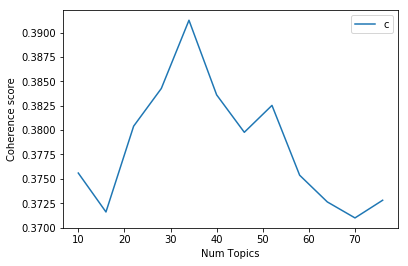

In [18]:
# Show graph
limit=80; start=10; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.3756
Num Topics = 16  has Coherence Value of 0.3716
Num Topics = 22  has Coherence Value of 0.3804
Num Topics = 28  has Coherence Value of 0.3843
Num Topics = 34  has Coherence Value of 0.3913
Num Topics = 40  has Coherence Value of 0.3836
Num Topics = 46  has Coherence Value of 0.3798
Num Topics = 52  has Coherence Value of 0.3825
Num Topics = 58  has Coherence Value of 0.3754
Num Topics = 64  has Coherence Value of 0.3726
Num Topics = 70  has Coherence Value of 0.371
Num Topics = 76  has Coherence Value of 0.3728


### In the next section we will clean the training sample as before and then we pass it to the MALLET model we trained  with k=35 topics.

### 

In [28]:
# Import Dataset
file = 'testreviews2.xlsx'

xl2 = pd.ExcelFile(file)

df2 = xl2.parse('Sheet1') 

df2.head()

# Convert to list
data2 = df2.userReview.values.tolist()

# Remove new line characters
data2 = [re.sub('\s+', ' ', sent) for sent in data2]

# Remove distracting single and double quotes
data2 = [re.sub("\'", "", sent) for sent in data2]
data2 = [re.sub('\", "', '', sent) for sent in data2]
data2 = [re.sub('\\"', '', sent) for sent in data2]
data2 = [re.sub('\"', '', sent) for sent in data2]
data2 = [re.sub('[\\:"]', '', sent) for sent in data2]

# Remove web links
data2 = [re.sub(r'^https?:\/\/.*[\r\n]*', '', sent) for sent in data2]

pprint(data2[:3])

['[ What may be the years best film so far(I havent seen Deadpool), the movie '
 'totally lives up to the hype. I was expecting a lot based on the really high '
 'rotten tomatoes score, at one point it was at 100%. It is really something '
 'you never seen before because its an animated movie. However this movie is '
 'creative, dark, silly, fun, entertaining, touching, scary, and even '
 'surprising at times. The plot was very well constructed and it really does '
 'give a great message to everyone. Its also very creative at times and '
 'somethings were mindblowing. However, I think the biggest win for the film '
 'is its humor. If youve seen the trailer, youd probably know what Im talking '
 'about. However, theres a lot more throughout the movie, espicially the '
 'ending. All the voices also fitted perfectly and the film was also very '
 'touching, and sad. I think this film should at least deserve an oscar '
 'nomination for best animated film. I really think this is one of the v

In [29]:
data_words2 = list(sent_to_words(data2))

print(data_words2[:3])

[['what', 'may', 'be', 'the', 'years', 'best', 'film', 'so', 'far', 'havent', 'seen', 'deadpool', 'the', 'movie', 'totally', 'lives', 'up', 'to', 'the', 'hype', 'was', 'expecting', 'lot', 'based', 'on', 'the', 'really', 'high', 'rotten', 'tomatoes', 'score', 'at', 'one', 'point', 'it', 'was', 'at', 'it', 'is', 'really', 'something', 'you', 'never', 'seen', 'before', 'because', 'its', 'an', 'animated', 'movie', 'however', 'this', 'movie', 'is', 'creative', 'dark', 'silly', 'fun', 'entertaining', 'touching', 'scary', 'and', 'even', 'surprising', 'at', 'times', 'the', 'plot', 'was', 'very', 'well', 'constructed', 'and', 'it', 'really', 'does', 'give', 'great', 'message', 'to', 'everyone', 'its', 'also', 'very', 'creative', 'at', 'times', 'and', 'somethings', 'were', 'mindblowing', 'however', 'think', 'the', 'biggest', 'win', 'for', 'the', 'film', 'is', 'its', 'humor', 'if', 'youve', 'seen', 'the', 'trailer', 'youd', 'probably', 'know', 'what', 'im', 'talking', 'about', 'however', 'theres'

In [30]:
# Build the bigram and trigram models
bigram2 = gensim.models.Phrases(data_words2, min_count=5, threshold=75) # higher threshold fewer phrases.
trigram2 = gensim.models.Phrases(bigram[data_words2], threshold=75)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod2 = gensim.models.phrases.Phraser(bigram2)
trigram_mod2 = gensim.models.phrases.Phraser(trigram2)

D:\programs\anaconda\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [31]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod2[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod2[bigram_mod2[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [32]:
# Remove Stop Words
data_words_nostops2 = remove_stopwords(data_words2)

# Form Bigrams
data_words_bigrams2 = make_bigrams(data_words_nostops2)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized2 = lemmatization(data_words_bigrams2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [33]:
# Create Dictionary
id2word2 = corpora.Dictionary(data_lemmatized2)

# Create Corpus
texts2 = data_lemmatized2

# Term Document Frequency
corpus2 = [id2word.doc2bow(text) for text in texts2]

In [34]:
def format_topics_sentences(ldamodel=lda_mallet, corpus=corpus2, texts=data2):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_mallet, corpus=corpus2, texts=data2)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,28.0,0.3402,"good, great, story, action, watch, movie, char...",[ What may be the years best film so far(I hav...
1,1,28.0,0.2166,"good, great, story, action, watch, movie, char...","[ For the very first time, I watched a film in..."
2,2,17.0,0.3112,"animation, kid, disney, animate, pixar, voice,...",[ Having to be succeeded by the awful Frozen a...
3,3,17.0,0.3455,"animation, kid, disney, animate, pixar, voice,...",[ Yet another top-of-the-line installment in D...
4,4,19.0,0.2407,"story, character, audience, world, work, feel,...","[ Zootropolis, like its animals, have a panora..."
5,5,28.0,0.4021,"good, great, story, action, watch, movie, char...",[ One of the best animated movies of this year...
6,6,32.0,0.2504,"performance, good, great, make, story, film, c...","[ Zootopia, what to say about this masterpiece..."
7,7,28.0,0.3178,"good, great, story, action, watch, movie, char...",[ Now thats a Disney movie that deserve a Osca...
8,8,17.0,0.3172,"animation, kid, disney, animate, pixar, voice,...",[ This movie has characters that are approved ...
9,9,28.0,0.2017,"good, great, story, action, watch, movie, char...",[ It was like the good and old animations came...


In [35]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics
df_dominant_topics.to_csv('topic_document.csv')

In [36]:
new_topics = lda_mallet[corpus2]

In [37]:
df_results = pd.DataFrame(new_topics)
df_results.head

<bound method NDFrame.head of                                0                            1   \
0       (0, 0.049357865081226485)   (1, 0.0005442309525214139)   
1       (0, 0.021938919362690414)    (1, 0.005614300187857877)   
2       (0, 0.004166996321429489)    (1, 0.005400362645029037)   
3       (0, 0.004332073560233818)   (1, 0.0012125887372437245)   
4       (0, 0.004332073560233818)   (1, 0.0012125887372437243)   
5       (0, 0.003871911550257419)   (1, 0.0010837849986076015)   
6        (0, 0.01753720791207627)    (1, 0.010016011638472027)   
7       (0, 0.004332073560233818)   (1, 0.0012125887372437243)   
8        (0, 0.05986571250757068)   (1, 0.0013761374573408199)   
9       (0, 0.004704841983186846)   (1, 0.0013169301767387061)   
10      (0, 0.010283736027844239)   (1, 0.0009493316465606512)   
11       (0, 0.00416699632142949)    (1, 0.001166382042512849)   
12      (0, 0.010479598260160093)    (1, 0.005985204638418854)   
13      (0, 0.002290712521991724)  (1, 0.00031

In [38]:
final = pd.concat([df2, df_results], axis=1)
final.to_csv('output5.csv')